In [1]:
import sys
sys.path.append("/home/dsetter/diem")

import derek_diem as diem

import time
import os
import multiprocessing
import numpy as np
import pandas as pd
import csv


import matplotlib.pyplot as plt
import kernel_smoothing_functions as ks

import pandas as pd

import csv

np.set_printoptions(legacy = '1.25')


# functions

In [2]:


def calc_hi_from_state_matrix(stateMatrix_):
    HIs = []
    for individual in stateMatrix_:
        numOnes = np.count_nonzero(individual==1)
        numTwos = np.count_nonzero(individual==2)
        numThrees = np.count_nonzero(individual==3)

        hi = ( numOnes * 0 + numTwos*1 + numThrees*2)/(2*(numOnes + numTwos + numThrees))
        HIs.append(hi)
    return HIs



def sort_stateMatrix(stateMatrix):
    # this sorts the stateMatrix by the data in it, i.e. only for the single chromosome used, not whole genome data
    HIs = np.array(calc_hi_from_state_matrix(stateMatrix))
    orderingHIs = np.argsort(HIs)
    stateMatrixSorted = stateMatrix[orderingHIs]

    HI_for_sorted = np.array(calc_hi_from_state_matrix(stateMatrixSorted))
    center = diem.get_hz_center(HI_for_sorted)
    print("hybrid indices for sorted stateMatrix")
    print(HI_for_sorted)
    
    print("center HI of barrier", center)
    barrierBreakIdx = sum(HI_for_sorted <center)
    print("barrier break index is ", barrierBreakIdx)
    print("note that markerConfigMatrix[0][0:barrierBreakIdx] yields the marker states for inividuals on the left side of the barrier")

    return stateMatrixSorted, HI_for_sorted,center, barrierBreakIdx

def get_config_DI_and_count(markerConfigMatrix,dfMarkers):
    dictDI = {}
    dictCount = {}
    for idx1 in range(len(markerConfigMatrix)):
        config = tuple([int(i) for i in markerConfigMatrix[idx1]])
        if not config in dictDI:
            dictDI[config] = dfMarkers["DI"][idx1]
            
        if config in dictCount:
            dictCount[config] +=1
        else:
            dictCount[config] = 1
    return dictDI, dictCount

def get_config_DI_and_count_v2(markerConfigMatrix,DIvals):
    dictDI = {}
    dictCount = {}
    for idx1 in range(len(markerConfigMatrix)):
        config = tuple([int(i) for i in markerConfigMatrix[idx1]])
        if not config in dictDI:
            dictDI[config] = DIvals[idx1]
            
        if config in dictCount:
            dictCount[config] +=1
        else:
            dictCount[config] = 1
    return dictDI, dictCount

def local_import_polarized_data(inputHapStringFiles_,inputMarkerFiles_,chrLengths_):
    
    stateMatrixByChr = []
    positionsByChr = []
    polarityByChr = []
    DIByChr = []
    mapPosByChr = []
    
    for idx in range(len(inputHapStringFiles_)):
    
        #get state matrices
        df = pd.read_csv(inputHapStringFiles_[idx])
    
        stateMatrix = np.zeros((len(df['0']),len(df['0'][1])),dtype = np.int8)-1
        for indIdx,ind in enumerate(df['0']):
            for charIdx,char in enumerate(ind):
                if char == '_':
                    char = 0
                else:
                    char = int(char)+1
                stateMatrix[indIdx][charIdx] = char


        #get the rest of the info
        df = pd.read_csv(inputMarkerFiles_[idx],sep='\t')
        pos = np.array(df['positions'])
        pol = np.array(df['polarity'])
        DI = np.array(df['DI'])
        mapPos = pos/chrLengths_[idx]

    
        positionsByChr.append(pos)
        polarityByChr.append(pol)
        DIByChr.append(DI)
        mapPosByChr.append(mapPos)
        stateMatrixByChr.append(stateMatrix)


    return stateMatrixByChr, positionsByChr, polarityByChr, DIByChr, mapPosByChr


def remove_missing(stateMatrixByChr, positionsByChr, polarityByChr, DIByChr, mapPosByChr):

    smbc = []
    posbc = []
    polbc = []
    dibc = []
    mpbc = []

    for idx in range(len(stateMatrixByChr)):
        sm = stateMatrixByChr[idx]
        pos = positionsByChr[idx]
        pol = polarityByChr[idx]
        DI = DIByChr[idx]
        mapPos = mapPosByChr[idx]
        
        trans = sm.transpose()
        thisFilter = trans==0
        thisFilter = np.array([sum(x)==0 for x in thisFilter])

        trans = trans[thisFilter]
        sm = trans.transpose()
        pos = pos[thisFilter]
        pol = pol[thisFilter]
        DI = DI[thisFilter]
        mapPos = mapPos[thisFilter]

        smbc.append(sm)
        posbc.append(pos)
        polbc.append(pol)
        dibc.append(DI)
        mpbc.append(mapPos)

    return smbc,posbc,polbc,dibc,mpbc
    
def sort_stateMatrixByChr(stateMatrixByChr_,DIByChr_):

    stateMatrix = np.hstack(stateMatrixByChr_)
    # this sorts the stateMatrix by the data in it, i.e. only for the single chromosome used, not whole genome data
    HIs = np.array(calc_hi_from_state_matrix(stateMatrix))
    orderingHIs = np.argsort(HIs)
    stateMatrixSorted = stateMatrix[orderingHIs]

    HI_for_sorted = np.array(calc_hi_from_state_matrix(stateMatrixSorted))
    centerByHI = diem.get_hz_center(HI_for_sorted)
    print("hybrid indices for sorted stateMatrix")
    print(HI_for_sorted)

    
    print("center HI of barrier", centerByHI)
    barrierBreakIdxByHI = sum(HI_for_sorted <centerByHI)
    print("barrier break based on hybrid index is ", barrierBreakIdxByHI)


    trans = stateMatrixSorted.transpose()
    DIs = np.hstack(DIByChr_)
    maxIdx = np.argmax(DIs)
    idealMarker = trans[maxIdx]
    leftType = idealMarker[0]
    barrierBreakIdxByIdealMarker = np.sum(idealMarker==leftType)

    print(' the ideal marker is', idealMarker)
    print(' break index based on ideal marker is', barrierBreakIdxByIdealMarker)
    
    print("note that markerConfigMatrix[0][0:barrierBreakIdx] yields the marker states for inividuals on the left side of the barrier")

    stateMatrixByChr_ = [x[orderingHIs] for x in stateMatrixByChr_]
    return stateMatrixByChr_, HI_for_sorted,centerByHI, barrierBreakIdxByHI, idealMarker, barrierBreakIdxByIdealMarker,orderingHIs



def apply_threshold(SMBC,PosBC,PolBC,DIBC,MapBC,threshold_):
    SMBC_=[np.copy(x) for x in SMBC]
    PosBC_=[np.copy(x) for x in PosBC]
    PolBC_=[np.copy(x) for x in PolBC]
    DIBC_ = [np.copy(x) for x in DIBC]
    MapBC_=[np.copy(x) for x in MapBC]
    toPrint = []
    for idx in range(len(SMBC_)):
        myFilter = DIBC_[idx]>=threshold_
        toPrint.append(sum(myFilter)/len(myFilter))
        trans = SMBC_[idx].transpose()
        trans = trans[myFilter]
        SMBC_[idx] = trans.transpose()
        PosBC_[idx] = PosBC_[idx][myFilter]
        PolBC_[idx] = PolBC_[idx][myFilter]
        DIBC_[idx] = DIBC_[idx][myFilter]
        MapBC_[idx] = MapBC_[idx][myFilter]
    print(toPrint)
    return SMBC_,PosBC_,PolBC_,DIBC_,MapBC_







# this function goes through the states for a single individual & chromosome 
# and it returns a list of intervals (class defined below)
# it ignores intervals made of only one type of marker,
# but one such marker will break up intervals... the data should be 
# smoothed over first anyway to avoid this issue

def get_intervals(cIdx,indIdx,statesList,posList,mapPosList):
    lidx = 0
    ridx = 0
    ivls = []
    while ridx <= len(statesList)-1:

        if ridx == len(statesList)-1:
            l = posList[lidx]
            r = posList[ridx]
            ml = mapPosList[lidx]
            mr = mapPosList[ridx]
            mapSpan = mr - ml
            iv = Interval(cIdx,indIdx,lidx,ridx,l,r,currentState,mapSpan)
            if r-l>0: 
                ivls.append(iv)
            break
        currentState = statesList[lidx]
        if statesList[ridx+1] == currentState:
            ridx += 1
        else:
            l = posList[lidx]
            r = posList[ridx]
            ml = mapPosList[lidx]
            mr = mapPosList[ridx]
            mapSpan = mr - ml
            iv = Interval(cIdx,indIdx,lidx,ridx,l,r,currentState,mapSpan)
            if r-l>0: 
                ivls.append(iv)
            ridx +=1
            lidx=ridx
            currentState = statesList[lidx]
            
    return ivls



# the interval class is simply an interval!
# it is defined as the chromosomeIdx, left and right positions (indexed as idxl and idxr), physical position (l & r)
# the physical span (in base pairs), the map span (i.e. normalized by chromosome length as used for smoothing)
# as well as the state of the interval

class Interval:
    # c = str
    # l = float
    # r = float
    # idxl = int
    # idxr = int
    # state = int
    # span = float

    def __init__(self,cIdx,indIdx,idxl,idxr,l,r,state,mapSpan):
        self.chr = cIdx
        self.ind = indIdx
        self.idxl = idxl
        self.idxr = idxr
        self.l = l
        self.r = r
        self.state = state
        self.span = r-l
        self.mapSpan = mapSpan


    def info(self):
        print(f"chr = {self.chr}, ind = {self.ind}, l = {self.l}, r = {self.r}, state = {self.state}, span = {self.span}, mapSpan = {self.mapSpan}")


#the chromosome class contains the haplotype structure of a single chromosome.
# the individual and chromosome are indexedIt contains 
# for a single individual and single chromosome. Maybe 'individualChromsome' would be a better name?
# the individual is simply a list of the intervals (as defined above)
class Contig:
    # individual is a list of intervals pertaining to a single chromosome

    def __init__(self,chrIdx,chrName,indIdx,indName,HI,sex,AorS,intervalList,background,genus,species,length):
        # if intervalList = []:
        #     print('interval list must not be empty for chromsome ', chrName, ' and individual ', indName)
            
        
        # if intervalList is None:
        #     self.intervals = []
        #     self.num_intervals = len(self.intervals)

        # else:
        #     self.intervals = intervalList
        #     self.num_intervals = len(self.intervals)
        
        self.intervals = intervalList
        self.num_intervals = len(self.intervals)
        self.indIdx = indIdx
        self.chrIdx = chrIdx
        self.indName = indName
        self.chrName = chrName
        self.HI = HI
        self.sex = sex
        self.type = AorS #i.e. 'A' if autosome and 'S' if sex chromsoome
        self.background = background # 1 or 3, indicating which 'side' of the barrier it is on. 
        self.genus = genus
        self.species = species
        self.length = length
        
        # self.zeros = None
        # self.ones = None
        # self.twos = None
        # self.threes = None

        self.getZeroIntervals()
        self.getOneIntervals()
        self.getTwoIntervals()
        self.getThreeIntervals()
        
    
    def printIntervals(self,lim=10):
        print("formatting is as follows [leftPosition,rightPosition,state]")
        if lim is None:
            print([[x.l,x.r,x.state] for x in self.intervals]) 
        else:
            print([[x.l,x.r,x.state] for x in self.intervals[0:min(self.num_intervals,lim)]])

    def getZeroIntervals(self):
        zeros = []
        tot = 0
        for x in self.intervals:
            if x.state == 0:
                zeros.append(x)
                tot = tot + x.mapSpan
        self.zeros = zeros
        self.totZero = tot
            
    # def getZeroIntervals(self):
    #     if self.zeros is not None:
    #         return self.zeros
    #     else:
    #         zeros = []
    #         tot = 0
    #         for x in self.intervals:
    #             if x.state == 0:
    #                 zeros.append(x)
    #                 tot = tot + x.mapSpan
    #         self.zeros = zeros
    #         self.totZero = tot
    
    def getOneIntervals(self):
        ones = []
        tot = 0
        for x in self.intervals:
            if x.state == 1:
                ones.append(x)
                tot = tot + x.mapSpan
        self.ones = ones
        self.totOne = tot
       
    # def getOneIntervals(self):
    #     if self.ones is not None:
    #         return self.ones
    #     else:
    #         ones = []
    #         for x in self.intervals:
    #             if x.state == 1:
    #                 ones.append(x)
    #         self.ones = ones
    #         return ones
    def getTwoIntervals(self):
        twos = []
        tot = 0
        for x in self.intervals:
            if x.state == 2:
                twos.append(x)
                tot = tot + x.mapSpan
        self.twos = twos
        self.totTwo = tot
            
    # def getTwoIntervals(self):
    #     if self.twos is not None:
    #         return self.twos
    #     else:
    #         twos = []
    #         for x in self.intervals:
    #             if x.state == 2:
    #                 twos.append(x)
    #         self.twos = twos
    #         return twos

    def getThreeIntervals(self):
        threes = []
        tot = 0
        for x in self.intervals:
            if x.state == 3:
                threes.append(x)
                tot = tot + x.mapSpan
        self.threes = threes
        self.totThree = tot

            
    # def getThreeIntervals(self):
    #     if self.threes is not None:
    #         return self.threes
    #     else:
    #         threes = []
    #         for x in self.intervals:
    #             if x.state == 3:
    #                 threes.append(x)
    #         self.threes = threes
    #         return threes

#the diplotype class contains all the data.
# diplotype.chromsomes is a list with all the relevant information.
# each entry of this is a 'chromosome', and contains the 'individuals' coresponding to each (class defined above)
# once constructed, you can acces the haplotype of a specific chromsome and individual as
#diplotype.chromosome[chrIdx][indIdx]

class Diplotypes:

    num_individuals = int
    num_chromosomes = int

    
    #sortedStateMatrixByChr
    def __init__(self, sortedSMBC_ = None,posBC_ = None,mapPosBC_ = None,chrNames_=None,indNames_ = None,HIBCBI_= None,boolSexChr_ = None,
                 sexChrPloidies_=None,idealMarker_=None, genusName_ = None,speciesList_= None,chrLengths_=None):
        if sortedSMBC_ is None:
            self.num_individuals = 0
            self.num_chromosomes = 0
            self.chromosomes = [] #list of chromsomes, each chromosome a list of intervals for a single individual
        else:
            self.num_chromosomes = len(sortedSMBC_)
            self.num_individuals = len(sortedSMBC_[0])
            self.chromosomes = []
            
            for chrIdx,chrStateMatrix in enumerate(sortedSMBC_):
                for indIdx,indStates in enumerate(chrStateMatrix): #i.e. for the single-individual stateMatrix
                    theseIntervals = get_intervals(chrIdx,indIdx,indStates,posBC_[chrIdx],mapPosBC_[chrIdx])
                    thisChrName = chrNames_[chrIdx]
                    thisIndName = indNames_[indIdx]
                    thisHI = HIBCBI_[chrIdx][indIdx]
                    thisSpecies = speciesList_[indIdx]
                    length = chrLengths_[chrIdx]
                    if boolSexChr_[chrIdx] == 1:
                        AorS = 'S'
                    else:
                        AorS = 'A'
                    if sexChrPloidies_[indIdx] == 1:
                        sex = 'F'
                    else:
                        sex = 'M'
                    background = idealMarker_[indIdx]
                    thisContig = Contig(chrIdx,thisChrName,indIdx,thisIndName, thisHI,sex,AorS,theseIntervals,background,genus,thisSpecies,length)
                    self.chromosomes.append(thisContig)

    def get_chromosome(self,cIdx):
        # returns a list of the individuals for a single chromosome
        if cIdx >= self.num_chromosomes:
            print(f"there are not that many chromosomes. max index is {self.num_chromosomes - 1}")
            return 0
        else:
            res = [ thisContig for thisContig in self.chromosomes if thisContig.chrIdx==cIdx]
            return res

    def get_individual(self,iIdx):
        # returns a list of the chromosome-wise intervals for a single individual 
        # they are ordered in the chromosomes list so should be ordered when output, so if data was sorted in, it willb e sroted out too
        
        if iIdx >= self.num_individuals:
            print(f"there are not that many individuals. max index is {self.num_individuals - 1}")
            return 0
        else:
            res = [ thisContig for thisContig in self.chromosomes if thisContig.indIdx == iIdx]
            return res

    def get_contig(self,cIdx,iIdx):
        if iIdx>= self.num_individuals:
            print(f"there are not that many individuals. max index is {self.num_individuals - 1}")
            return 0
        elif cIdx >= self.num_chromosomes:
            print(f"there are not that many chromosomes. max index is {self.num_chromosomes - 1}")
            return 0
        else:
            res = [thisContig for thisContig in self.chromosomes if (thisContig.chrIdx == cIdx and thisContig.indIdx == iIdx)]
            return res[0]


def smooth_state_matrices(stateMatrixByChr_,mapPosByChr_,scale_):
    smoothed = []
    for idx in range(len(stateMatrixByChr_)):
        thisStateMatSmoothed = ks.laplace_smooth_multiple_haplotypes(mapPosByChr_[idx],stateMatrixByChr_[idx],scale_)
        smoothed.append(thisStateMatSmoothed)
    return smoothed


def plot_painting(stateMatrix_):
    # for a single chromosome in the 'stateMatrixByChromsome'
    mycmap = colors.ListedColormap(['w','g','y','b'])
    bounds = [-.5,.5,1.5,2.5,3.5]
    norm = colors.BoundaryNorm(bounds,mycmap.N)
    
    fig, ax = plt.subplots(figsize=(16,4))
    ax.pcolormesh(stateMatrix_, cmap = mycmap, norm=norm)
    ax.set_yticks([])
    ax.set_yticklabels([])
    plt.show()

def plot_all_spans(d_):
    # d_ is an instance of the Diplotype class
    print("spans for all individuals. blue = hom left allele, magenta = het, red = hom right")
    spans = []
    for thisChr in d_.chromosomes:
        spans = spans + [x.mapSpan for x in thisChr.getOneIntervals()]
    n,myBins,patches = plt.hist(spans,bins=1000,histtype='step',color='b')
    
    for thisChr in d_.chromosomes:
        spans = spans + [x.mapSpan for x in thisChr.getTwoIntervals()]
    plt.hist(spans,bins=1000,histtype='step',color='m')
    
    for thisChr in d_.chromosomes:
        spans = spans + [x.mapSpan for x in thisChr.getThreeIntervals()]
    plt.hist(spans,bins=1000,histtype='step',color='r')
    
    plt.yscale("log")
    plt.xscale("log")
    plt.show()
    
    
def plot_left_spans(d_,markerBreakIdx_):
    print("spans for individuals left of barrier. blue = hom left allele, magenta = het, red = hom right")
    spans = []
    for thisChr in d_.chromosomes:
        if thisChr.ind < markerBreakIdx_:
            spans = spans + [x.mapSpan for x in thisChr.getOneIntervals()]
    n,myBins,patches = plt.hist(spans,bins=1000,histtype='step',color='b')
    
    spans = []
    for thisChr in d_.chromosomes:
        if thisChr.ind < markerBreakIdx_:
            spans = spans + [x.mapSpan for x in thisChr.getTwoIntervals()]
    plt.hist(spans,bins=1000,histtype='step',color='m')
    
    spans = []
    for thisChr in d_.chromosomes:
        if thisChr.ind < markerBreakIdx_:
            spans = spans + [x.mapSpan for x in thisChr.getThreeIntervals()]
    plt.hist(spans,bins=1000,histtype='step',color='r')
    
    plt.yscale("log")
    plt.xscale("log")
    plt.show()
    
    
def plot_right_spans(d_,markerBreakIdx_):
    print("spans for individuals right of barrier. blue = hom left allele, magenta = het, red = hom right")
    spans = []
    for thisChr in d_.chromosomes:
        if thisChr.ind >= markerBreakIdx_:
            spans = spans + [x.mapSpan for x in thisChr.getOneIntervals()]
    n,myBins,patches = plt.hist(spans,bins=1000,histtype='step',color='b')
    
    spans = []
    for thisChr in d_.chromosomes:
        if thisChr.ind >= markerBreakIdx_:
            spans = spans + [x.mapSpan for x in thisChr.getTwoIntervals()]
    plt.hist(spans,bins=1000,histtype='step',color='m')
    
    spans = []
    for thisChr in d_.chromosomes:
        if thisChr.ind >= markerBreakIdx_:
            spans = spans + [x.mapSpan for x in thisChr.getThreeIntervals()]
    plt.hist(spans,bins=1000,histtype='step',color='r')
    
    plt.yscale("log")
    plt.xscale("log")
    plt.show()





def get_intro_amt_and_bias(lv,rv,brakeIdx,conf):
    conf = np.array(conf)
    lconf,rconf = [conf[0:brakeIdx], conf[brakeIdx:]]
    nl = 2*sum(lconf != 0)
    nr = 2*sum(rconf != 0 )
    if nl == 0 or nr==0:
        return(np.nan,np.nan)
    introAmount = (1*sum(lconf == 2) + 2*sum(lconf == rv) + 1*sum(rconf==2) + 2*sum(rconf==lv))/(nl+nr)
    lb = (1*sum(lconf==2) + 2*sum(lconf == rv))/nl
    rb = (1*sum(rconf == 2) + 2*sum(rconf == lv))/nr
    totb = -(lb - rb)
    return introAmount,totb



def storeData(SMBC_,posBC_,mapBC_,polBC_,diBC_,diplotype_,pathOut_):
    # SMBC_ should be the smoothed version
    # the remaining variables are pretty clear
    # it stores the information per-chromosme as a dictionary so easier to work with later. 
    dictBC = []
    for idx in range(len(posBC_)):
        md = {}
        md['basePos'] = posBC_[idx]
        md['mapPos'] = mapBC_[idx]
        md['pol'] = polBC_[idx]
        md['DI'] = diBC_[idx]
        dictBC.append(md)
    with open(pathOut_, 'wb') as f:
        pickle.dump([SMBC_,dictBC,diplotype_],f)

def readData(pathIn_):
    with open(pathIn_,'rb') as f:
        SMBC_,dictBC_,d_ = pickle.load(f)
    dfBC=[]
    for idx in range(len(dictBC_)):
        df = pd.DataFrame.from_dict(dictBC_[idx])
        dfBC.append(df)
    return SMBC_, dfBC, d_
    

In [3]:
def get_thresholds(SMBC_,DIBC_):
    sm = np.hstack(SMBC_)
    smt = sm.transpose()
    dis = np.concat(DIBC_)
    bestIdx = np.argmax(dis)
    idealMarker = smt[bestIdx]
    kmax = len(idealMarker)+1
    DIbyDiffs = np.zeros(kmax)
    
    for idx,markerConfig in enumerate(smt):
        
        kDiffs = sum(markerConfig != idealMarker)
        thisDI = dis[idx]
        if thisDI < DIbyDiffs[kDiffs]:
            DIbyDiffs[kDiffs] = thisDI
    return idealMarker, [[k,d] for k, d in enumerate(DIbyDiffs)]

def calc_contig_his(SMBC,sexPloidy,autoPloidy,isSexChr):
    #sexPloidy is a list of the ploidy of the individuals as ordered in SMBC
    #autoPloidy is a list of the ploidy (here, always twos) as for sexPloidy, ordered by SMBC!
    #isSexChr is a list with '1' indicating sex chr and '0' indicated autosome
    HIBC = []
    for idx,sm in enumerate(SMBC):

        am = diem.hapStateIndices_to_hapMatrix(sm.transpose())
        if isSexChr[idx]==1:
            ploidyArr = sexPloidy[:,np.newaxis]
        else:
            ploidyArr = autoPloidy[:,np.newaxis]
        am = am*ploidyArr
        A4 = np.sum(am,axis=0)
        his = diem.get_hybrid_index(A4)
        HIBC.append(his)

    return np.array(HIBC)

def sort_by_HI(SMBC_,HIByChrByInd_,sampleNames_,sexPloidies_,idealMarker_):
    thisSMBC = SMBC_.copy()
    thisHIByChrByInd = HIByChrByInd_.copy()
    theseNames = np.array(sampleNames_)
    thesePloidies = np.array(sexPloidies_)
    HIByInd = np.mean(thisHIByChrByInd.transpose(),axis= -1)
    ordering = np.argsort(HIByInd)

    for idx in range(len(thisSMBC)):
        thisSMBC[idx] = thisSMBC[idx][ordering]
        thisHIByChrByInd[idx] = thisHIByChrByInd[idx][ordering]
    theseNames = theseNames[ordering]
    thesePloidies = thesePloidies[ordering]
    HIByInd = HIByInd[ordering]
    idealMarker_ = idealMarker_[ordering]
    return thisSMBC,thisHIByChrByInd,theseNames,thesePloidies,HIByInd,idealMarker_
    
    
    
def storeData(SMBC_,posBC_,mapBC_,diplotype_,dataframe_,pathOut_):
    # SMBC_ should be the smoothed version
    # the remaining variables are pretty clear
    # it stores the information per-chromosme as a dictionary so easier to work with later. 
    with open(pathOut_, 'wb') as f:
        pickle.dump([SMBC_,posBC_,mapBC_,diplotype_,dataframe_],f)

def readData(pathIn_):
    with open(pathIn_,'rb') as f:
        SMBC_,posBC_,mapBC_,diplotype_,dataframe_ = pickle.load(f)
    return SMBC_,posBC_,mapBC_,diplotype_,dataframe_ 

In [4]:
from matplotlib import colors

mycmap = colors.ListedColormap(['w','g','y','b'])
bounds = [-.5,.5,1.5,2.5,3.5]
norm = colors.BoundaryNorm(bounds,mycmap.N)

mycmap2 = colors.ListedColormap(['LightGray','w','g','y','b'])
bounds2 = [-1.5,-.5,.5,1.5,2.5,3.5]
norm2 = colors.BoundaryNorm(bounds2,mycmap2.N)

# running diem

In [5]:
thisGenus = 'iphiclides'

In [6]:
outPath = './0_pairs/'+thisGenus+'/diem_output'
if not os.path.exists(outPath):
    print('creating output directory')
    os.makedirs(outPath)
else:
    print('output directory already exists but...')
    dl = os.listdir(outPath)
    if len(dl)==0:
        print('there is no output, so proceeding')
        print()
    else:
        print('output already exists. I will not overwrite those files. delete them and run again')
        quit()

output directory already exists but...
there is no output, so proceeding



In [7]:
tempdf = pd.read_csv("./iphiclides_test_data/"+thisGenus+"_samples.txt",header=None,sep=' ')
sampleNames = list(tempdf[1])
#print(sampleNames)
autosomePloidy = np.array([2 for x in sampleNames])
sexChrPloidy = np.array(list(tempdf[0]))

In [8]:
tempdf = pd.read_csv("./iphiclides_test_data/"+thisGenus+"_chrom_5.csv",header=None)
chrLengths = np.array(tempdf[1])
chrNames = np.array(tempdf[0])
boolIsSexChr = np.array(tempdf[2])

autosomeNames = chrNames[boolIsSexChr == 0]
sexChrNames = chrNames[boolIsSexChr==1]

In [9]:
inBaseBed = './iphiclides_test_data/iphiclides_diem_files/' + thisGenus + '/diem_files/annotations/included/per_chromosome/'
autosomeBedFiles = [inBaseBed+x+'.included.annotations.bed' for x in autosomeNames]
sexChrBedFiles = [inBaseBed+x+'.included.annotations.bed' for x in sexChrNames]
markerBedFiles = autosomeBedFiles + sexChrBedFiles
positionsByChr = [diem.get_marker_pos_from_bed(x) for x in markerBedFiles]

In [10]:
inBaseDiem = './iphiclides_test_data/iphiclides_diem_files/' + thisGenus + '/diem_files/diem_input/per_chromosome/'
autosomeDiemFiles = [inBaseDiem+x+'.diem_input.txt' for x in autosomeNames]
sexChrDiemFiles = [inBaseDiem + x+'.diem_input.txt' for x in sexChrNames]
compartmentFiles = [autosomeDiemFiles,sexChrDiemFiles]
compartmentPloidies = [autosomePloidy,sexChrPloidy]
individualsIncluded = list(range(len(sampleNames)))

In [11]:
MArray, PloidyArray, contigFilesIn, contigSplices = diem.get_diem_input(compartmentFiles,compartmentPloidies,individualsIncluded)

time in seconds to import this contig 4.352323055267334


In [12]:
def plot_and_save_painting(stateMatrix_,fileOutName):
    # for a single chromosome in the 'stateMatrixByChromsome'
    mycmap = colors.ListedColormap(['w','g','y','b'])
    bounds = [-.5,.5,1.5,2.5,3.5]
    norm = colors.BoundaryNorm(bounds,mycmap.N)
    
    fig, ax = plt.subplots(figsize=(8,4))
    ax.pcolormesh(stateMatrix_, cmap = mycmap, norm=norm)
    ax.set_yticks([])
    ax.set_yticklabels([])
    plt.savefig(fileOutName,bbox_inches='tight',dpi=300)
    plt.show()

In [13]:
hapStrings_input = diem.markerMatArry_to_haplotypeStrings(MArray)
hapIndices_input = diem.hapStrings_to_hapIndices(hapStrings_input)

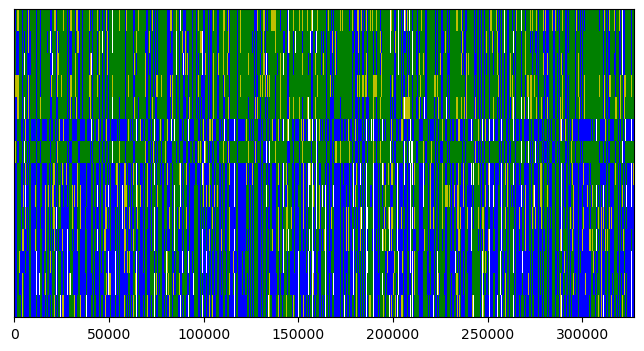

In [216]:
# plot_and_save_painting(hapIndices_input[::-1],"./figures/diem_input.png")

In [14]:
initPolarity,initMarray = diem.initialize_random_polarities(MArray)
hapStrings_random = diem.markerMatArry_to_haplotypeStrings(initMarray)
hapIndices_random = diem.hapStrings_to_hapIndices(hapStrings_random)

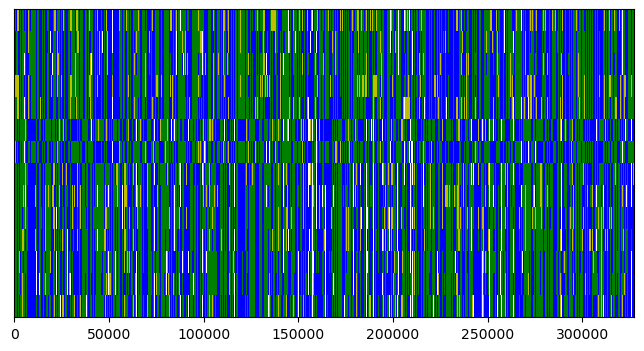

In [218]:
# plot_and_save_painting(hapIndices_random[::-1],'./figures/diem_random.png')

In [15]:
outA,outPhi,outDI,outS = diem.run_em(initMarray,initPolarity,PloidyArray,200,.99,32)

iteration  0
np0, np1  163790 163854
iteration  1
np0, np1  108213 219431
iteration  2
np0, np1  93674 233970
iteration  3
np0, np1  94600 233044
iteration  4
np0, np1  94674 232970
iteration  5
np0, np1  94669 232975
match to polarity at itt  5  found
polarity found


In [16]:
hapStrings_raw = diem.markerMatArry_to_haplotypeStrings(outA)
hapIndices_raw = diem.hapStrings_to_hapIndices(hapStrings_raw)

# plot_and_save_painting(hapIndices_raw[::-1],'./figures/diem_output.png')

In [17]:
outputHapStringFiles = ['./diem_out_iphiclides_chr_2/'+ x + '.hapStrings.txt' for x in np.concat((autosomeNames,sexChrNames))]
outputMarkerFiles = ['./diem_out_iphiclides_chr_2/'+ x + '.markerInfo.txt' for x in np.concat((autosomeNames,sexChrNames))]

diem.output_diem_results(outputHapStringFiles,outputMarkerFiles,positionsByChr,outA,outPhi,outDI,contigSplices)

# processing diem results

In [18]:
dfChr = pd.read_csv('./iphiclides_test_data/iphiclides_chrom_2.csv',
    header=None,
    names = ["chromosome",'length','ploidy'])

baseInFile = './diem_out_iphiclides_chr_2/'
inputHapStringFiles = [baseInFile + c + ".hapStrings.txt" for c in dfChr["chromosome"]]
inputMarkerFiles = [baseInFile + c + ".markerInfo.txt" for c in dfChr["chromosome"]]

In [19]:
sampleFile = './iphiclides_test_data/iphiclides_samples.txt'
df = pd.read_csv(sampleFile,header=None,sep=' ')
sampleNames = np.array(df[1])
sexChrPloidies = np.array(df[0])
autosomePloidies = np.array([2 for _ in sexChrPloidies])
print(sampleNames)
print(sexChrPloidies)

['IP_RVcoll14H960' 'IP_RVcoll14F754' 'IP_RVcoll14E561' 'IP_504' 'IP_502'
 'IF_142' 'IP_RVcoll12R048' 'IF_236' 'IF_165' 'IF_234' 'IF_RVcoll14B411'
 'IF_RVcoll12N508' 'IF_RVcoll11F366' 'IF_RVcoll17B439']
[1 2 1 2 2 1 2 2 2 2 1 1 2 2]


In [20]:
start = time.time()
SMBC,PosBC,PolBC,DIBC,MapBC = local_import_polarized_data(inputHapStringFiles,inputMarkerFiles,dfChr["length"])
print('time in seconds ', time.time() - start)

time in seconds  1.78536057472229


## sorting

In [21]:
sm = np.hstack(SMBC)
vals = np.array([np.sum(sm==0,axis = -1), np.sum(sm==1,axis = -1), np.sum(sm==2,axis = -1), np.sum(sm==3,axis = -1)])
print([_/(_+a+b+c) for _,a,b,c in list(zip(*vals))])
[[a/(a+b+c), b/(a+b+c), c/(a+b+c)] for _,a,b,c in list(zip(*vals))]

[0.009877167833150631, 0.01314332293335582, 0.01438850943024988, 0.002068752283778846, 0.012406892093206286, 0.041515585912246675, 0.016094667903420748, 0.04341006830255502, 0.04793546392332124, 0.0306743120555415, 0.03817916069370661, 0.04799730162745594, 0.04810692301205835, 0.03787840458723332]


[[0.8417883584665697, 0.08638603742732558, 0.07182560410610465],
 [0.8510057135695853, 0.052783585022814404, 0.09621070140760024],
 [0.8493601900465135, 0.057253508474237914, 0.0933863014792486],
 [0.8541914295532259, 0.06991161409893137, 0.07589695634784274],
 [0.8491359191247624, 0.07975671398809185, 0.0711073668871458],
 [0.2280557184750733, 0.07827565982404693, 0.6936686217008797],
 [0.8936419421558432, 0.037960942052999054, 0.06839711579115769],
 [0.22759648102113855, 0.0786716266168321, 0.6937318923620294],
 [0.2265880560705724, 0.07813330341643146, 0.6952786405129961],
 [0.24106803689645273, 0.08426391228828181, 0.6746680508152655],
 [0.22978079237376053, 0.07591170909473476, 0.6943074985315048],
 [0.21446202176595983, 0.03927734178934377, 0.7462606364446964],
 [0.21193249767462463, 0.04030355376415526, 0.7477639485612201],
 [0.2298725656891444, 0.07644597918748211, 0.6936814551233734]]

In [22]:
start = time.time()
SMBC_noMiss ,PosBC_noMiss,PolBC_noMiss,DIBC_noMiss,MapBC_noMiss = remove_missing(SMBC,PosBC,PolBC,DIBC,MapBC)
print('time in seconds ', time.time() - start)

time in seconds  1.2666149139404297


In [23]:
start = time.time()
idealMarker, DIByDiffs = get_thresholds(SMBC_noMiss,DIBC_noMiss)
print('time in seconds ',time.time() - start)
DIByDiffs # a list of thresholds as a function of number that diff
thisThreshold = DIByDiffs[2][1] #this is the threshold for up-to two missing
thisThreshold


time in seconds  1.2706646919250488


-16.082916597732833

In [24]:
start = time.time()
HIByChrByInd = calc_contig_his(SMBC,sexChrPloidies,autosomePloidies,dfChr['ploidy'])
print('time in seconds ', time.time() - start)
HIByChrByInd

time in seconds  2.966196298599243


array([[0.11501862, 0.12260249, 0.12201306, 0.11085276, 0.11098572,
        0.73280645, 0.08737759, 0.73306771, 0.73434529, 0.71680001,
        0.73226335, 0.76589931, 0.76791573, 0.73190444]])

In [25]:
sortedSMBC,sortedHIByChrByInd,sortedSampleNames,sortedSexPloidies,sortedMeanHIBI,sortedIdealMarker = sort_by_HI(SMBC,HIByChrByInd,sampleNames,sexChrPloidies,idealMarker)


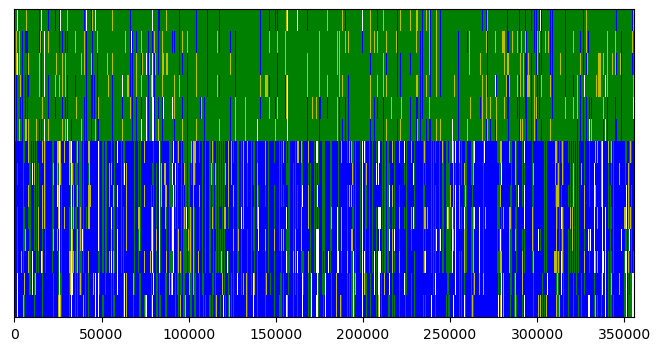

In [230]:
# plot_and_save_painting(sortedSMBC[0][::-1],'./figures/diem_output_sorted.png')

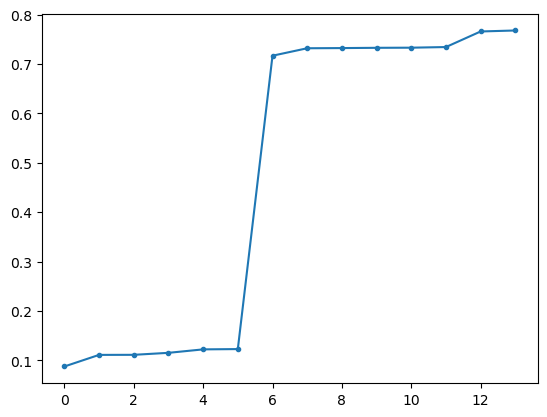

In [249]:
# plt.plot(sortedMeanHIBI,marker='.')
# plt.savefig('./figures/hybrid_index.png')
# plt.show()

In [28]:
start = time.time()
sortedSMBC_noMiss,PosBC_noMiss,PolBC_noMiss,DIBC_noMiss,MapBC_noMiss = remove_missing(sortedSMBC,PosBC,PolBC,DIBC,MapBC)
print('time in seconds ', time.time() - start)


time in seconds  1.2724065780639648


In [29]:

start = time.time()
HIByChrByInd = calc_contig_his(SMBC_noMiss,sexChrPloidies,autosomePloidies,dfChr['ploidy'])
print('time in seconds ', time.time() - start)
HIByChrByInd

time in seconds  2.6921606063842773


array([[0.11321496, 0.11968434, 0.11924702, 0.1078619 , 0.11020962,
        0.73600658, 0.08589231, 0.73743033, 0.73741389, 0.72944513,
        0.73733005, 0.77336621, 0.77618907, 0.73756679]])

In [73]:
# plt.plot(sortedMeanHIBI_noMiss,marker='.')
# plt.show()

In [74]:
# plot_painting(sortedSMBC_noMiss[0])

In [30]:
# sortedSMBC,sortedHIByChrByInd,sortedSampleNames,sortedSexPloidies,sortedMeanHIBI,sortedIdealMarker = sort_by_HI(SMBC_thresh_smoothed,HIByChrByInd,sampleNames,sexChrPloidies,idealMarker)
# plot_painting(sortedSMBC[3])

NameError: name 'SMBC_thresh_smoothed' is not defined

## thresholding

without missing, all counts vs unique dist


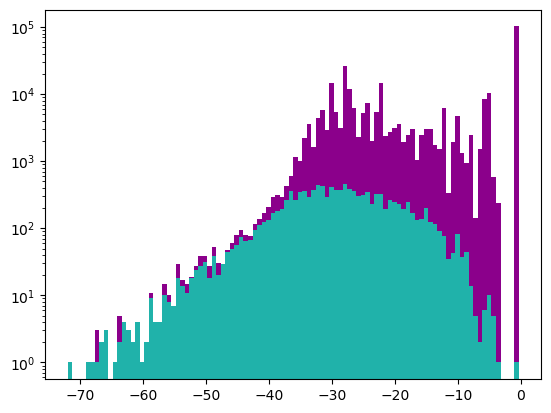

In [31]:
print('without missing, all counts vs unique dist')
(counts,bins,patches)=plt.hist(np.hstack(DIBC_noMiss),bins=100,color='darkmagenta')
plt.hist(np.unique(np.hstack(DIBC_noMiss)),bins=bins,color='lightseagreen')
plt.yscale('log')
plt.savefig('./figures/histogram.png',bbox_inches='tight')
plt.show()

In [32]:
markerConfigMatrix = np.hstack(sortedSMBC_noMiss).transpose()
DIs = np.hstack(DIBC_noMiss)

dictDI,dictCount = get_config_DI_and_count_v2(markerConfigMatrix,DIs)
keyList = list(dictDI.keys())
DIList = [dictDI[key] for key in keyList]
CountList = [dictCount[key] for key in keyList]
df1 = pd.DataFrame(data = {"configuration":keyList,"count":CountList,"DI":DIList})
df1.sort_values(by="DI",ascending=False)



,configuration,count,DI
0,"(1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3)",101979,-0.328503
940,"(1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3)",235,-3.589320
208,"(1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3)",115,-3.985100
1333,"(1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3)",120,-3.995331
1390,"(1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3)",105,-4.020503
...,...,...,...
7792,"(2, 2, 1, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2)",1,-66.924233
10841,"(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3)",3,-67.325908
8377,"(2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2)",1,-68.345040
7907,"(1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2)",1,-68.505695


In [33]:
df1[df1['DI']>-16].sort_values(by="DI",ascending=False)

,configuration,count,DI
0,"(1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3)",101979,-0.328503
940,"(1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3)",235,-3.589320
208,"(1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3)",115,-3.985100
1333,"(1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3)",120,-3.995331
1390,"(1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3)",105,-4.020503
...,...,...,...
10803,"(3, 1, 2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3)",1,-15.941819
11488,"(1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3)",1,-15.959029
1076,"(1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1)",68,-15.959832
368,"(1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1)",60,-15.970729


In [34]:
start = time.time()
idealMarker, DIByDiffs = get_thresholds(sortedSMBC_noMiss,DIBC_noMiss)
print('time in seconds ',time.time() - start)
DIByDiffs # a list of thresholds as a function of number that diff
thisThreshold = DIByDiffs[2][1] #this is the threshold for up-to two missing
thisThreshold


time in seconds  1.3310303688049316


-16.082916597732833

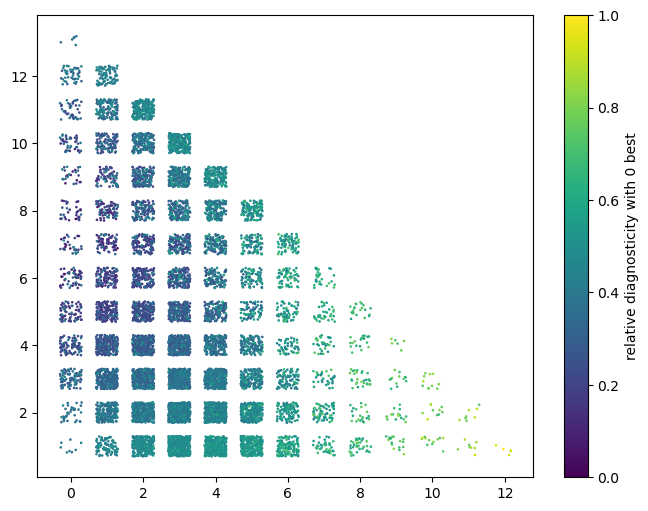

In [35]:

cl = np.array(list(df1['configuration']))
di = np.array(list(df1['DI']))

n_twos =np.array([sum(c==2) for c in cl])
n_threes = np.array([sum(c==3) for c in cl])

shading = -di
shading = (shading - np.min(shading))/(np.max(shading) - np.min(shading))
# shading = -(shading-1)

n_twos_spread= np.array([x+np.random.uniform(-.3,.3) for x in n_twos])
n_threes_spread = np.array([x+np.random.uniform(-.3,.3) for x in n_threes])

plt.figure(figsize=(8,6))
plt.scatter(n_twos_spread,n_threes_spread,c = shading, cmap = 'viridis',s=.75)
plt.colorbar(label = 'relative diagnosticity with 0 best')
left,right = plt.xlim()
bottom,top = plt.ylim()
plt.show()




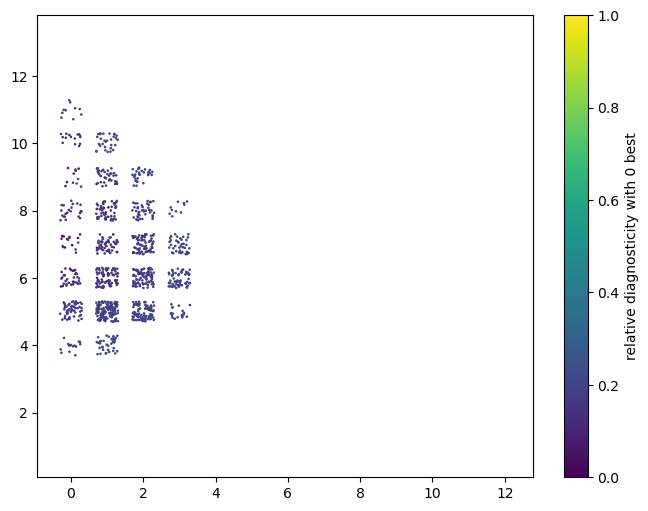

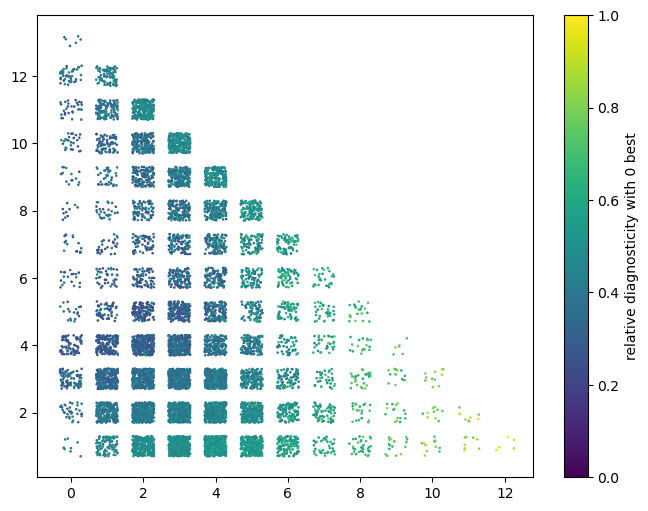

In [36]:
thresh = thisThreshold
filt = di>thresh
di_filt = di[filt]
cl_filt = cl[filt]
shading_filt = shading[filt]
scaleMin = np.min(shading)
scaleMax = np.max(shading)

n_twos =np.array([sum(c==2) for c in cl_filt])
n_threes = np.array([sum(c==3) for c in cl_filt])
n_twos_spread= np.array([x+np.random.uniform(-.3,.3) for x in n_twos])
n_threes_spread = np.array([x+np.random.uniform(-.3,.3) for x in n_threes])

plt.figure(figsize=(8,6))
plt.scatter(n_twos_spread,n_threes_spread,c = shading_filt, cmap = 'viridis',vmin = scaleMin,vmax = scaleMax,s=.75)
plt.colorbar(label = 'relative diagnosticity with 0 best')
plt.xlim(left,right)
plt.ylim(bottom,top)
plt.show()

filt = di<thresh
di_filt = di[filt]
cl_filt = cl[filt]
shading_filt = shading[filt]
scaleMin = np.min(shading)
scaleMax = np.max(shading)

n_twos =np.array([sum(c==2) for c in cl_filt])
n_threes = np.array([sum(c==3) for c in cl_filt])
n_twos_spread= np.array([x+np.random.uniform(-.3,.3) for x in n_twos])
n_threes_spread = np.array([x+np.random.uniform(-.3,.3) for x in n_threes])

plt.figure(figsize=(8,6))
plt.scatter(n_twos_spread,n_threes_spread,c = shading_filt, cmap = 'viridis',vmin = scaleMin,vmax = scaleMax,s=.75)
plt.colorbar(label = 'relative diagnosticity with 0 best')
plt.xlim(left,right)
plt.ylim(bottom,top)
plt.show()

In [37]:
lv = idealMarker[0]
rv = idealMarker[-1]
breakIdx = sum(idealMarker==idealMarker[0])
res = []
for conf in df1["configuration"]:
    amt,bias = get_intro_amt_and_bias(lv,rv,breakIdx,conf)
    res.append([amt,bias])
res = np.array(res)
res = res.transpose()
df1["introAmount"] = res[0]
df1["introBias"] = res[1]

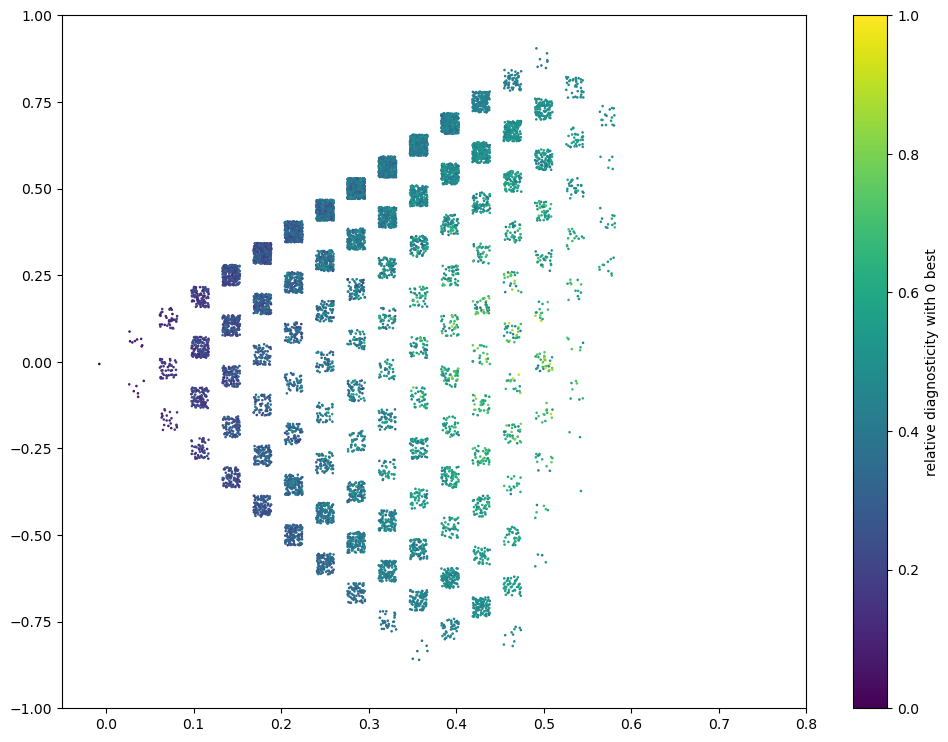

In [38]:
shading = - np.array(df1["DI"])
shading = (shading - np.min(shading))/(np.max(shading) - np.min(shading))

introScatter = np.array([x + np.random.uniform(-.01,.01) for x in df1["introAmount"]])
biasScatter = np.array([x + np.random.uniform(-.03,.03) for x in df1["introBias"]])
plt.figure(figsize=(12,9))
plt.scatter(introScatter,biasScatter,s=.75,c = shading, cmap = 'viridis')
plt.colorbar(label = 'relative diagnosticity with 0 best')
plt.ylim(-1,1)
plt.xlim(-.05,0.8)
# plt.savefig("./figures/admix_bias_di_all.png")
plt.show()

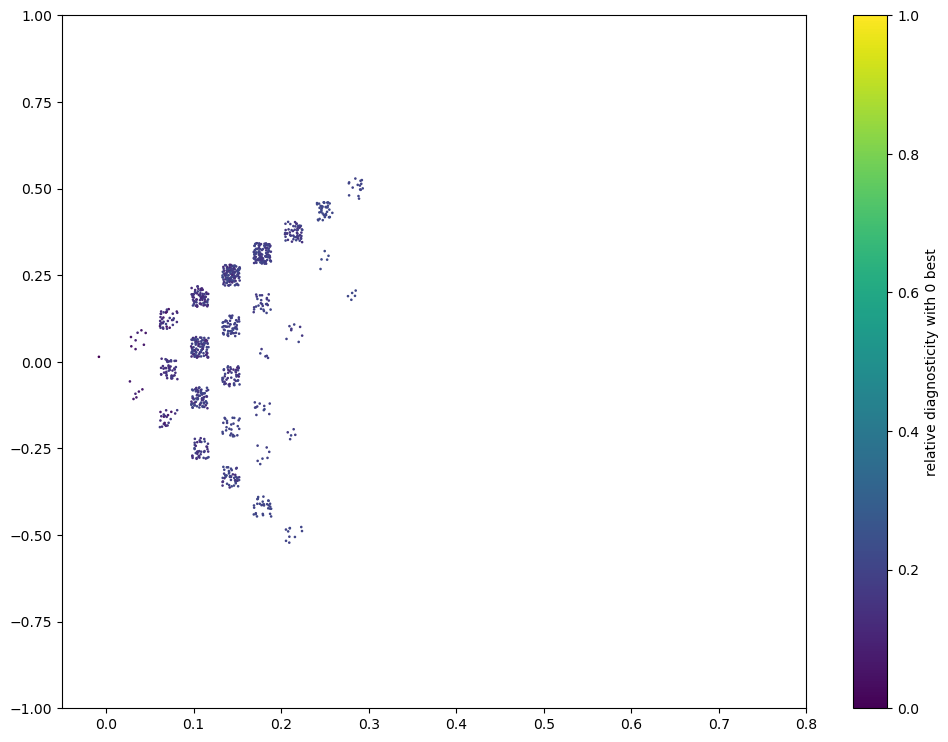

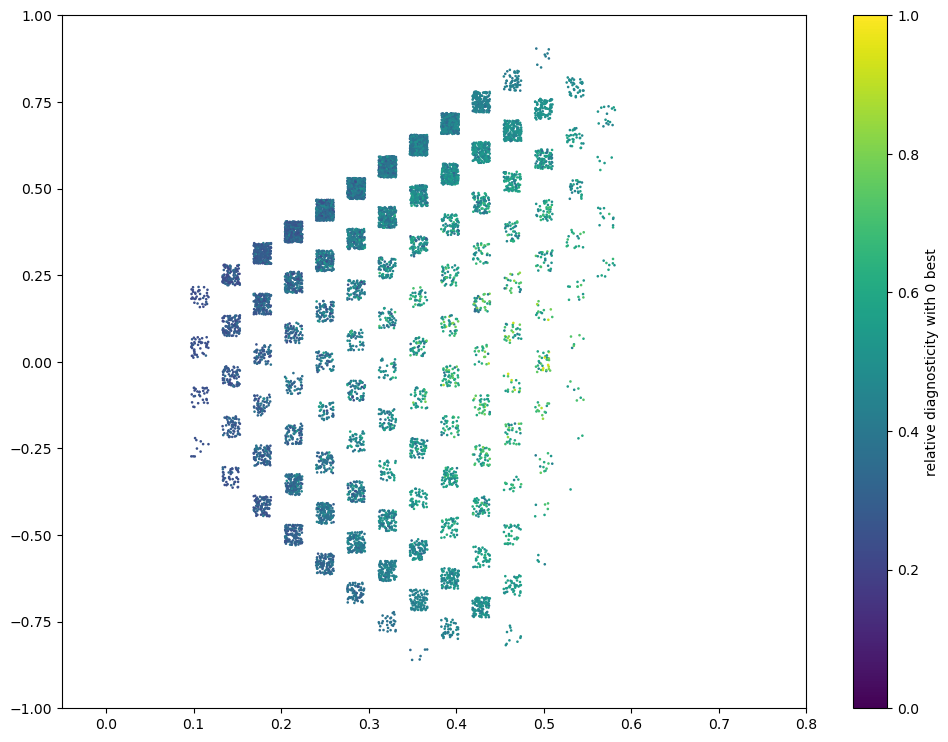

In [39]:
thresh = thisThreshold
filt = df1["DI"]>thresh
di_filt = df1["DI"][filt]
cl_filt = df1["configuration"][filt]
shading_filt = shading[filt]
scaleMin = np.min(shading)
scaleMax = np.max(shading)

introScatter = np.array([x + np.random.uniform(-.01,.01) for x in df1["introAmount"][filt]])
biasScatter = np.array([x + np.random.uniform(-.03,.03) for x in df1["introBias"][filt]])
plt.figure(figsize=(12,9))
plt.scatter(introScatter,biasScatter,s=.75,c = shading_filt, cmap = 'viridis',vmin = scaleMin,vmax = scaleMax)
plt.colorbar(label = 'relative diagnosticity with 0 best')
plt.ylim(-1,1)
plt.xlim(-.05,0.8)
# plt.savefig('./figures/admix_bias_di_keep.png')
plt.show()

filt = df1["DI"]<thresh
di_filt = df1["DI"][filt]
cl_filt = df1["configuration"][filt]
shading_filt = shading[filt]
scaleMin = np.min(shading)
scaleMax = np.max(shading)

introScatter = np.array([x + np.random.uniform(-.01,.01) for x in df1["introAmount"][filt]])
biasScatter = np.array([x + np.random.uniform(-.03,.03) for x in df1["introBias"][filt]])
plt.figure(figsize=(12,9))
plt.scatter(introScatter,biasScatter,s=.75,c = shading_filt, cmap = 'viridis',vmin = scaleMin,vmax = scaleMax)
plt.colorbar(label = 'relative diagnosticity with 0 best')
plt.ylim(-1,1)
plt.xlim(-.05,0.8)
# plt.savefig('./figures/admix_bias_di_remove.png')
plt.show()

[0.4587289540995587]

time in seconds  0.05991649627685547


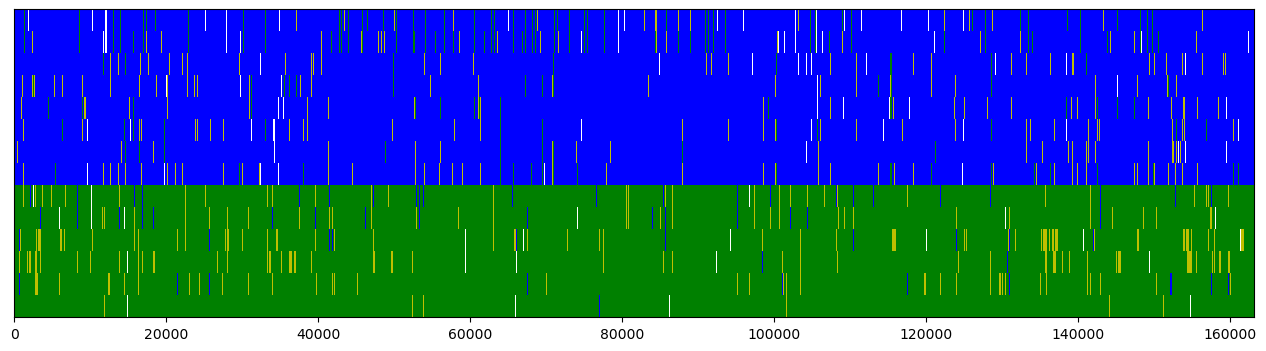

In [40]:
start = time.time()
SMBC_thresh,PosBC_thresh,PolBC_thresh,DIBC_thresh,MapBC_thresh = apply_threshold(sortedSMBC,PosBC,PolBC,DIBC,MapBC,thisThreshold)
print()
print('time in seconds ', time.time() - start)

plot_painting(SMBC_thresh[0])

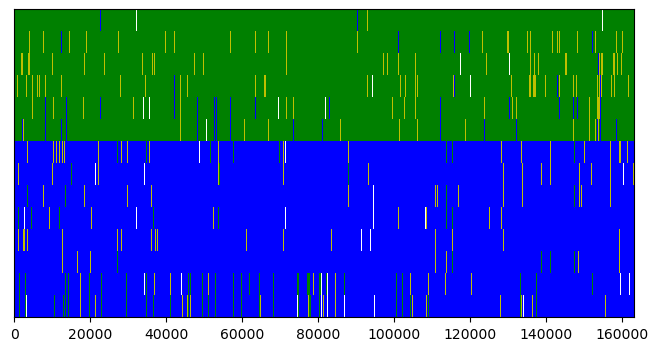

In [243]:
plot_and_save_painting(SMBC_thresh[0][::-1],'./figures/diem_output_sorted_thresholded.png')

## smoothing

In [145]:
smoothing_scale = 1e-4
SMBC_thresh_smoothed = smooth_state_matrices(SMBC_thresh, MapBC_thresh,smoothing_scale)
kSitesChanged = np.sum(SMBC_thresh[0] != SMBC_thresh_smoothed[0])

163202

In [49]:
scales = [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4,1e-3,5e-3]
res = []
kMarkers = len(SMBC_thresh[0][0])*len(SMBC_thresh[0])
for scale in scales:
    SMBC_thresh_smoothed = smooth_state_matrices(SMBC_thresh, MapBC_thresh,scale)
    kSitesChanged = np.sum(SMBC_thresh[0] != SMBC_thresh_smoothed[0])
    res.append([scale,kSitesChanged/kMarkers])
res = np.array(res)
res


array([[1.00000000e-07, 7.44038501e-06],
       [5.00000000e-07, 9.46679575e-04],
       [1.00000000e-06, 2.66409550e-03],
       [5.00000000e-06, 1.44321586e-02],
       [1.00000000e-05, 2.12501773e-02],
       [5.00000000e-05, 3.20269184e-02],
       [1.00000000e-04, 3.50236429e-02],
       [5.00000000e-04, 3.98345083e-02],
       [1.00000000e-03, 4.14696424e-02],
       [5.00000000e-03, 4.53802212e-02]])

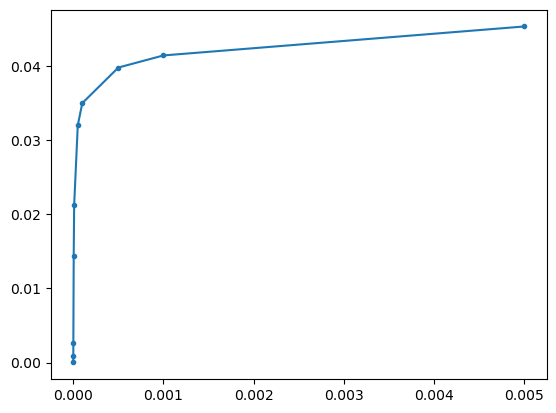

In [50]:
plt.plot(res.transpose()[0],res.transpose()[1],marker = '.')
plt.show()

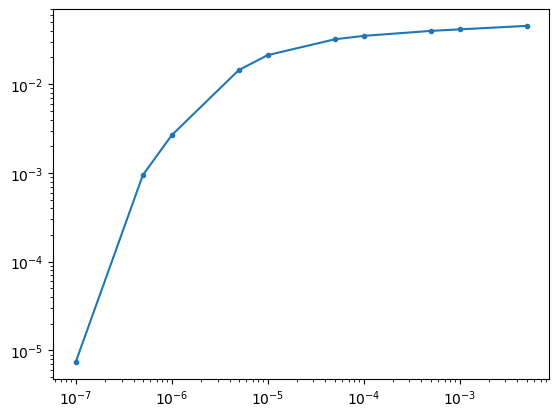

In [63]:
y = res.transpose()[1]
y[y==0]=1
plt.plot(res.transpose()[0],y,marker='.')
plt.xscale('log')
plt.yscale('log')
plt.savefig('./figures/smoothing_kernel.png',bbox_inches='tight',dpi=300)

plt.show()

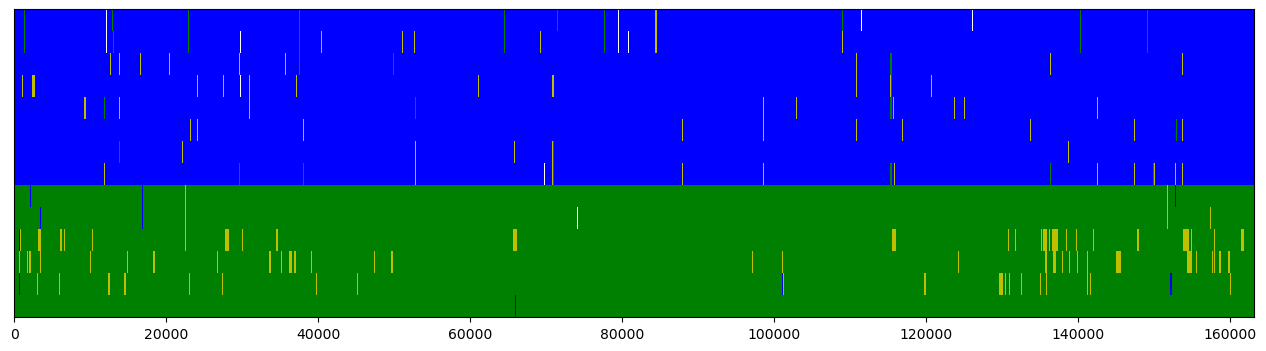

In [64]:
SMBC_thresh_smoothed = smooth_state_matrices(SMBC_thresh, MapBC_thresh,1e-4)
plot_painting(SMBC_thresh_smoothed[0])

In [59]:
# plot_and_save_painting(SMBC_thresh_smoothed[0][::-1],'./figures/diem_output_sorted_thresholded_smoothed.png')

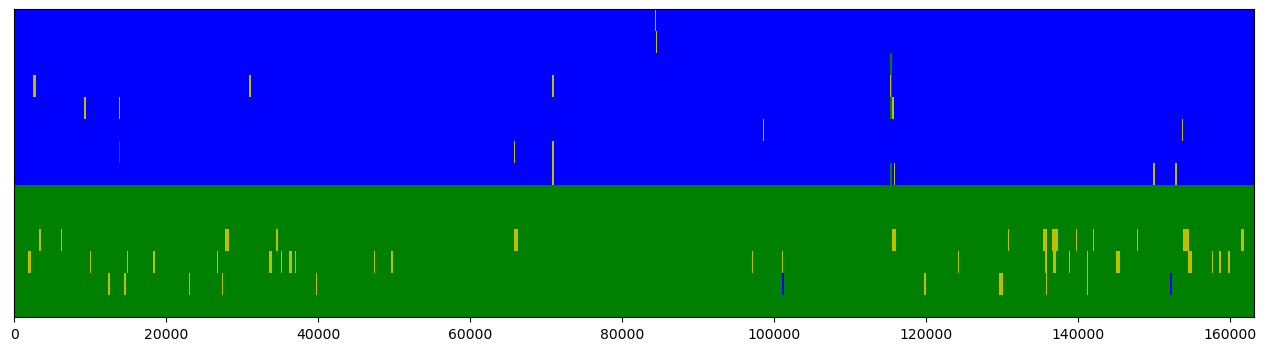

In [61]:
# SMBC_thresh_smoothed = smooth_state_matrices(SMBC_thresh, MapBC_thresh,5e-4)
# plot_painting(SMBC_thresh_smoothed[0])

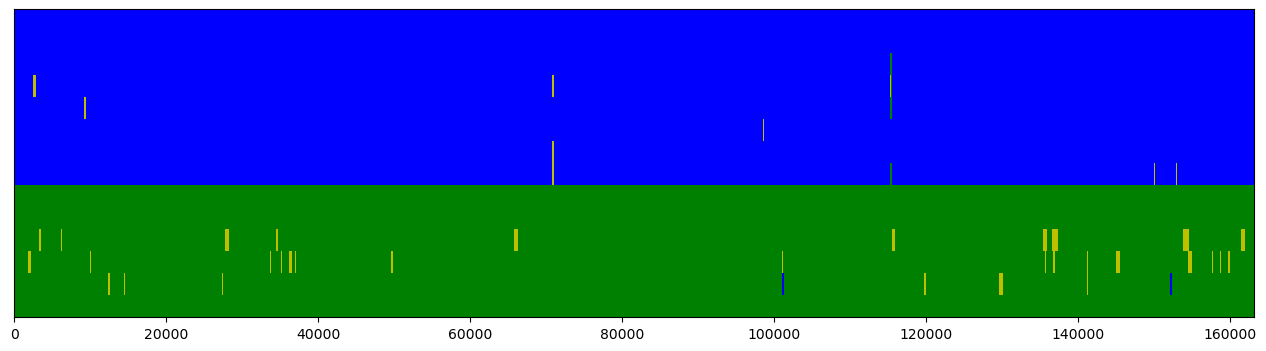

In [56]:
# SMBC_thresh_smoothed = smooth_state_matrices(SMBC_thresh, MapBC_thresh,1e-3)
# plot_painting(SMBC_thresh_smoothed[0])

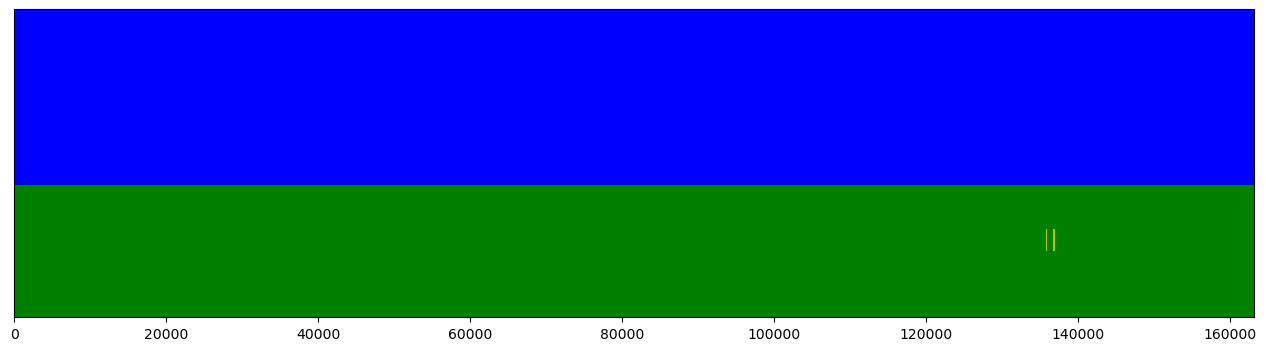

In [60]:
# SMBC_thresh_smoothed = smooth_state_matrices(SMBC_thresh, MapBC_thresh,5e-3)
# plot_painting(SMBC_thresh_smoothed[0])

In [246]:

start = time.time()
HIByChrByInd = calc_contig_his(SMBC_thresh_smoothed,sexChrPloidies,autosomePloidies,dfChr['ploidy'])
print('time in seconds ', time.time() - start)


sortedSMBC_final ,sortedHIByChrByInd_final ,sortedSampleNames_final ,sortedSexPloidies_final ,sortedMeanHIBI_final ,sortedIdealMarker_final  = sort_by_HI(SMBC_thresh_smoothed ,HIByChrByInd,sampleNames,sexChrPloidies,idealMarker)


time in seconds  1.394512414932251


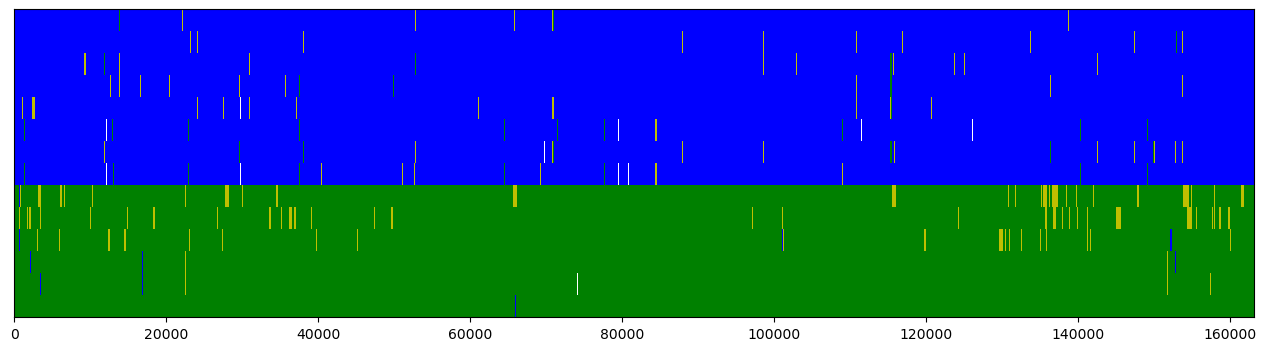

In [247]:
plot_painting(sortedSMBC_final[0])

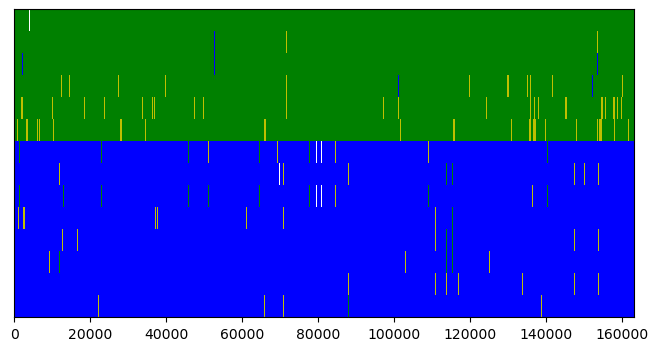

In [248]:
plot_and_save_painting(sortedSMBC_final[0][::-1],'./figures/diem_output_thresholded_smoothed_resorted.png')

**the above must then be re-sorted by HI now that we are properly focusing on the relevant variation**

**do this for the plot for the poster**

## diplotypes class and plotting stuff about haplotype lengths

In [206]:
kSitesChaged = np.sum(SMBC_thresh[0] != SMBC_thresh_smoothed[0])

In [201]:
SMBC_thresh_smoothed == SMBC_thresh

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()